In [126]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Dataset**

In [127]:
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

In [128]:
# To speed up training we'll only work on a subset of the data
x_train = mnist_trainset.data[:1000].view(-1, 784).float()
targets_train = mnist_trainset.targets[:1000]

x_valid = mnist_trainset.data[1000:1500].view(-1, 784).float()
targets_valid = mnist_trainset.targets[1000:1500]

x_test = mnist_testset.data[:500].view(-1, 784).float()
targets_test = mnist_testset.targets[:500]

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

# normalize the inputs
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)

Information on dataset
x_train torch.Size([1000, 784])
targets_train torch.Size([1000])
x_valid torch.Size([500, 784])
targets_valid torch.Size([500])
x_test torch.Size([500, 784])
targets_test torch.Size([500])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

**Network**

In [129]:
class ScoreNetwork0(torch.nn.Module):
    # takes an input image and time, returns the score function
    def __init__(self):
        super().__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(2, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        x2 = torch.reshape(x, (*x.shape[:-1], 1, 28, 28))  # (..., ch0, 28, 28)
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 28, 28)  # (..., 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        return signal

score_network = ScoreNetwork0()

**Define loss and optimizer**

In [159]:
#optimizer
opt = torch.optim.AdamW(score_network.parameters(), lr=1e-4)

#loss
loss_MSE = torch.nn.MSELoss()

**Define parameters**

In [155]:
#number of transformations in Forward process
T = 1000
#variance schedule 
betas = torch.linspace(0.001, 0.002, T)  #myb should be sorted or we can check out the SDE thing so we need no variance schedule
#the cumulative alpha 
alphas = 1 - betas
alpha_calculate_cumulative = lambda idx: torch.prod(alphas[:idx+1])
#epochs
max_epochs = 10000
#convergence check
convergence_threshold = 1e-6 

**Traininig**

In [160]:
def training(losses):
    
    previous_loss = 0
    for i in range(max_epochs):

        #sample training params 
        x_0_np = x_train[np.random.choice(x_train.shape[0])] 
        x_0 = torch.tensor(x_0_np).to(device)  # Convert to tensor and move to device
        x_0 = x_0.view(1, 28*28)

        #t = torch.rand((1, 1), dtype=x_0.dtype, device=x_0.device) * (1 - 1e-4) + 1e-4
        #t = torch.randint(1, T + 1, (1, 1), dtype=x_0.dtype, device=x_0.device) / T
        t = torch.randint(1, T + 1, (1, 1), dtype=torch.int64, device=x_0.device)

        epsilon = torch.randn_like(x_0)   #N(0,1)

        #create noisy observation
        alpha_ = alpha_calculate_cumulative(t).detach()
        x_noisy = torch.sqrt(alpha_)*x_0 + torch.sqrt(1-alpha_)*epsilon

        #train 
        epsilon_hat = score_network(x_noisy, t)  #forward pass
        loss = loss_MSE(epsilon, epsilon_hat)    #calculate loss
        opt.zero_grad()                          #reset grad
        loss.backward()                          #backprop
        opt.step()                               #train params


        #stop training until loss converged
        current_loss = loss.item()
        losses.append(current_loss)
        if abs(previous_loss - current_loss) < convergence_threshold:
            break
        previous_loss = current_loss


C:\Users\evaka\AppData\Local\Temp\ipykernel_14892\2039349313.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = torch.tensor(x_0_np).to(device)  # Convert to tensor and move to device


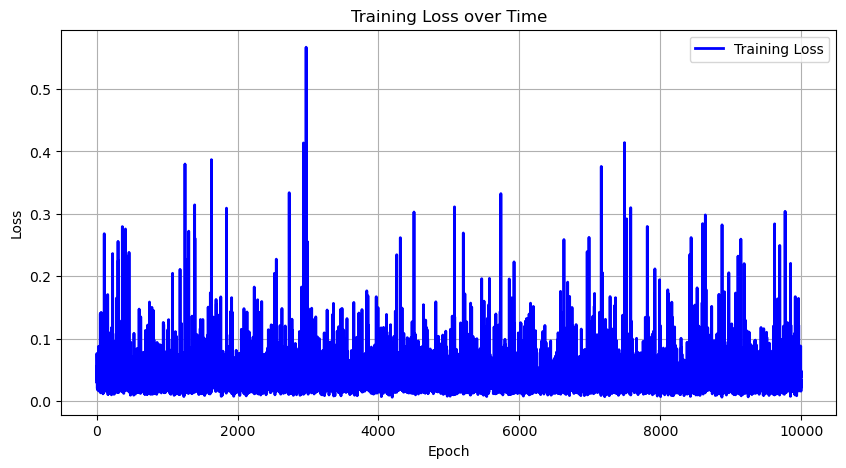

0.03992817550897598


In [161]:
def plot_loss(losses):
    """
    Plots the training loss over time.

    Parameters:
    losses (list or array): A list of loss values over epochs or iterations.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss', color='blue', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

losses = []
training(losses)
plot_loss(losses)
print(losses[-1])

**Sampling**

In [148]:
def sampling():
    with torch.no_grad(): #turn of grad 
        score_network.eval() #turn of dropout and similar

        #generate noise sample
        x_T = x_previous_t = torch.randn(1, 784, device=device)
        x_0 = None
        #removing the noise for each transition
        for t in range(T-1, 1, -1):

            #set noise 
            z =  torch.zeros_like(x_T)      #special case when it's the last transition 1->0
            if t > 1:
                z = torch.randn_like(x_T)   #otherwise, N(0,1) 

            #remove noise for this timestep transition
            alpha_t = alphas[t]
            beta_t = betas[t]
            alpha_cum_t = alpha_calculate_cumulative(t).item()
            variance_t = beta_t             #variance of p_theta we have to choose based on x_0 - for now this since x_0 ~ N(0,I) 
        
            time = torch.tensor([[t]], dtype=torch.int64, device=x_T.device)
            epsilon_hat = score_network(x_previous_t, time)

            x_previous_t = (1/np.sqrt(alpha_t))*(x_previous_t - ((1-alpha_t)/np.sqrt(1-alpha_cum_t))*epsilon_hat) + (variance_t*z)
            
            x_0 = x_previous_t #remember last for return

    #return final calculated x_0
    return x_0


0 sample
1 sample
2 sample
3 sample
4 sample


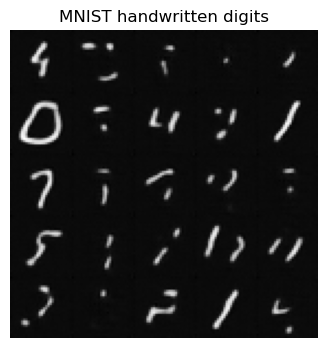

In [163]:
# plot a few MNIST examples
idx, dim, classes = 0, 28, 5

# create empty canvas
canvas = np.zeros((dim * classes, classes * dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        # Detach the tensor and convert it to a NumPy array
        canvas[i * dim:(i + 1) * dim, j * dim:(j + 1) * dim] = sampling().detach().reshape((dim, dim)).numpy()

    print(str(i) + ' sample')

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()
